# Multi-class Calssification

For this example, we will use one-vs-all logistic regression and <a href="https://github.com/Mr-MayankThakur/Machine-Learning-Implementations-with-Numpy/tree/master/Neural%20Networks">neural networks</a> to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
example will show you how the methods you’ve learned can be used for this
classification task.
In the first part of the example, we will extend our previous implemention of logistic regression and apply it to one-vs-all classification.

**NOTE: The example and sample data is being taken from the "Machine Learning course by Andrew Ng" in Coursera.**

## Dataset

We are given a data set in ex3data1.mat that contains 5000 training examples of handwritten digits. The .mat format means that that the data has
been saved in a native Octave/MATLAB matrix format, instead of a text
(ASCII) format like a csv-file. These matrices can be read directly into your
program by using the loadmat command from scipy.io library.

In [1]:
# initial imports
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# imports from my models
from models.data_preprocessing import add_bias_unit
from models.logistic_regression import cost_function, predict, gradient_descent, gradient_function, sigmoid

In [3]:
# loading dataset
import scipy.io as sio  # sio for loading matlab file .mat
data = sio.loadmat('data/ex3data1.mat')
X = data['X']  # (5000, 400)
y = data['y']  # (5000, 1)

There are 5000 training examples in ex3data1.mat, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training
example for a handwritten digit image.

$$X = \begin{bmatrix}\dots & \left( x^{(1)} \right)^{T}  & \dots \\
\dots & \left( x^{(2)} \right)^{T} & \dots \\
& \vdots & \\ 
\dots & \left( x^{(m)} \right)^{T} & \dots\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector y that
contains labels for the training set. To make things more compatible with
Octave/MATLAB indexing, where there is no zero index, we have mapped
the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while
the digits “1” to “9” are labeled as “1” to “9” in their natural order.

## Loading and Visualizing Data

We will begin by visualizing a subset of the training set. the below code randomly selects 100 rows from X using random.choice function and maps each row to a 20 pixel by
20 pixel grayscale image and displays the images together.

Note: This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)

In [4]:
# Setting up initial variables we will be needing for the script.
input_layer_size  = 400  # 20x20 Input Images of Digits
num_labels = 10          # 10 labels, from 1 to 10
                         # (note that we have mapped "0" to label 10)

print('Loading and Visualizing Data ...')

m = X.shape[0]

print("Randomly selecting 100 data points to display")
rand_indices = np.random.choice(range(0,m), 100)
rand_samples = X[rand_indices, :]

Loading and Visualizing Data ...
Randomly selecting 100 data points to display


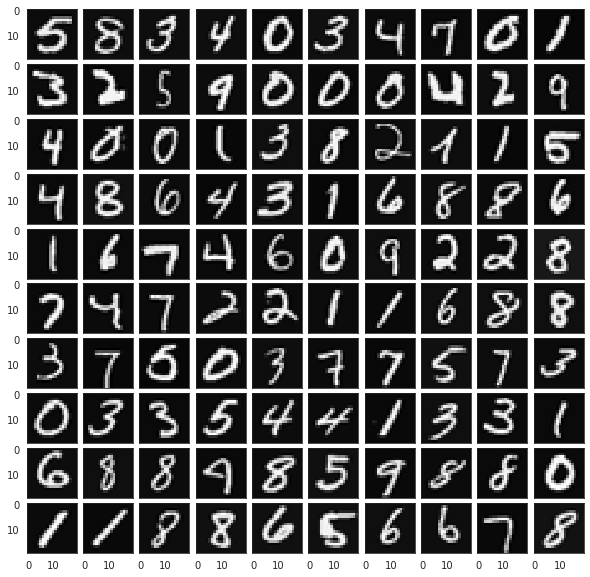

In [5]:
# displaying the 100 random samples using matplotlib
sns.set_style('white')
fig, axis = plt.subplots(10,10,sharex=True, sharey=True, figsize=(10,10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
axis_flt = axis.flatten()
for i in range(100):
    axis_flt[i].imshow(rand_samples[i, :].reshape([20,20]).T, cmap='gray')

## Vectorize Logistic Regression

In this part of the example, We will reuse our logistic regression code from the last exercise. Our task here is to make sure that our regularized logistic regression implementation is vectorized. After that, we will implement one-vs-all classification for the handwritten digit dataset.

We will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, you will need to train 10
separate logistic regression classifiers. To make this training efficient, it is
important to ensure that your code is well vectorized.

#### Test case for CostFunction

In [6]:
print('\nTesting logistic regression CostFunction() with regularization')
theta_t = np.array([-2, -1, 1, 2]).reshape(4,1)

X_t = np.hstack([np.ones([5,1]), np.arange(1,16).reshape(5,3, order='F')/10.0])
y_t = (np.array([1,0,1,0,1]) >= 0.5).astype(np.int64).reshape(5,1)
lambda_t = 3

J = cost_function(theta_t, X_t, y_t, lambda_t, regularized=True)
grad = gradient_function(theta_t, X_t, y_t, lambda_t, regularized=True)

print('\nCost: {:.6f}\n'.format(J[0,0]))
print('Expected cost: 2.534819\n')
print('Gradients: {}'.format(grad))
print('Expected gradients: [0.146561 -0.548558 0.724722 1.398003]')


Testing logistic regression CostFunction() with regularization

Cost: 2.534819

Expected cost: 2.534819

Gradients: [ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients: [0.146561 -0.548558 0.724722 1.398003]


## One-vs-All Training

Here we are going to Train num_labels(10 in our case) logistic regression classifiers and return each of these classifiers in a matrix all_theta, where the i-th row of all_theta corresponds to the classifier for label i.

We will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset. 


In the handwritten digits dataset, K = 10, but our code should work for any value of K. In particular, our code should return all the classifier parameters
in a matrix Θ ∈ R<sup>K×(N+1)</sup> , where each row of Θ corresponds to the learned
logistic regression parameters for one class. You can do this with a “for”-loop
from 1 to K, training each classifier independently.
Note that the y argument to this function is a vector of labels from 1 to
10, where we have mapped the digit “0” to the label 10 (to avoid confusions
with indexing).
When training the classifier for class k ∈ {1, ..., K}, you will want a mdimensional vector of labels y, where y$_{j}$ ∈ 0, 1 indicates whether the j-th
training instance belongs to class k (y$_{1}$ = 1), or if it belongs to a different
class (y$_{j}$ = 0). You may find logical arrays helpful for this task.

In [7]:
print('Training One-vs-All Logistic Regression...')

lamda = 0.1
X_bias = add_bias_unit(X)
n=X_bias.shape[1]

# mapping zeros in 'y' back to 0 instead of 10
y[y==10] = 0

from scipy.optimize import minimize

op_list = []

for i in np.arange(num_labels):
    initial_theta = np.zeros(n)
    op_list.append(minimize(fun=cost_function, x0=initial_theta, jac=gradient_function, args=(X_bias, (y==i), lamda, True), method='CG'))

Training One-vs-All Logistic Regression...


## One-vs-all Prediction

As we have trained our one-vs-all classifier, we can now use it to predict the
digit contained in a given image. For each input, it should compute the
“probability” that it belongs to each class using the trained logistic regression
classifiers. Our one-vs-all prediction function will pick the class for which the
corresponding logistic regression classifier outputs the highest probability and
return the class label (1, 2,..., or K) as the prediction for the input example.

In [8]:
all_theta = np.ones([n, num_labels])  # to store the values of all the individual thetas into one

for i, op in enumerate(op_list):
    all_theta[:,i] = op.x
    
temp = sigmoid(X_bias @ all_theta) # predictions on each example with each classifier
p = temp.argmax(axis=1).reshape(m,1)  # selecting the number(index) for which classifier is most confident

print("The Accuracy of our classifier is: {:.2f}%".format((p==y).mean()*100))

In [16]:
print('prediction for the random samples displayed in earlier part of this example')

random_samples_pred = sigmoid(add_bias_unit(rand_samples) @ all_theta)
p_rand = random_samples_pred.argmax(axis=1)

print(p_rand.reshape([10,10]))

prediction for the random samples displayed in earlier part of this example
[[5 8 3 4 0 3 4 7 0 1]
 [3 2 5 9 0 0 0 4 2 9]
 [4 0 0 1 3 8 2 1 1 5]
 [4 8 6 4 3 1 6 8 8 6]
 [1 6 7 4 6 0 9 2 2 8]
 [7 4 7 2 2 1 1 6 8 8]
 [3 7 5 0 3 7 7 5 7 8]
 [0 3 3 5 4 4 1 3 3 1]
 [6 8 8 9 8 5 9 8 8 0]
 [1 1 8 8 6 5 6 6 7 8]]
